In [14]:
from json import load
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.ndimage import label

DIRPATH = './maps/example_maps_odom_v6_003_waffle_counter_clockwise'
MAP_001 = 'map_20250330_222348_568341.json'

VAL_UNKNOWN = -1
VAL_FREE = 0
VAL_OCCUPIED = 100
VAL_INACCESSIBLE = 101

VAL_CURR_POSITION = 200
VAL_NEXT_GOAL = 201

VAL_ESTIMATED_WALL = 250

colormap = {
    VAL_UNKNOWN: [0.5, 0.5, 0.5],  # Gray (unknown terrain)
    VAL_FREE: [1.0, 1.0, 1.0],  # White (blank space)
    VAL_OCCUPIED: [0.0, 0.0, 0.0],  # Black (walls)
    VAL_INACCESSIBLE: [0.0, 1.0, 0.0],  # Green (estimated walls)
    
    VAL_CURR_POSITION: [1.0, 0.0, 0.0],  # Red (current position)
}

RESOLUTION = 0.03  # meters per pixel


## Input and output

In [15]:
def read_data_map(_dir_path: str=DIRPATH, _map_path: str=MAP_001) -> tuple[np.ndarray[tuple[()], np.dtype], float, float]:
    """Reads map data from a JSON file and returns the grid, origin x, and origin y.
    Args:
        _dir_path (str, optional): Directory path to the map file. Defaults to DIRPATH.
        _map_path (str, optional): Map file name. Defaults to MAP_001.

    Returns:
        _type_: _description_
    """
    
    _data = dict()
    with open(_dir_path + '/' + _map_path, 'r+') as json_data:
        _data = load(json_data)
        json_data.close()
    
    try:
        _data = _data['map']
        print(_data)

        width = _data['info']['width']
        height = _data['info']['height']
        origin_x = _data['info']['origin']['position']['x']
        origin_y = _data['info']['origin']['position']['y']
        _data = _data['data']

        grid = np.array(_data).reshape((height, width))

        return grid, origin_x, origin_y

    except:
        print('No data found in the map file')
    
    return None, None, None

def read_data_odom(_dir_path: str=DIRPATH, _odom_path: str=MAP_001) -> tuple[int, int]:
    _data = dict()
    with open(_dir_path + '/' + _odom_path, 'r+') as json_data:
        _data = load(json_data)
        json_data.close()
    
    try:
        _data = _data['odom']
        print(_data)

        x = _data['pose']['pose']['position']['x']
        y = _data['pose']['pose']['position']['y']

        return x, y

    except:
        print('No data found in the odom file')
    
    return None, None
    

def print_plot_v2(
    grid: np.ndarray[tuple[()], np.dtype],
    title: str="Original map",
    filename: str="Not provided",
    occupied: int=-1,
    free: int=-1,
    inaccessible: int=-1,
    unknown: int=-1,
    explored_percent: float=-1.0,
    position_x: float=-1,
    position_y: float=-1) -> None:
    height, width = grid.shape
    colored_map = np.zeros((height, width, 3))

    for y in range(height):
        for x in range(width):
            color_code = grid[y, x]
            colored_map[y, x] = colormap[color_code]
            
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(colored_map, origin='upper')
    plt.title(title)
    plt.axis('off')
    
    legend_text = (f"Filename: {filename}\n"
                   f"Occupied: {occupied}\n"
                   f"Free: {free}\n"
                   f"Inaccessible: {inaccessible}\n"
                   f"Unknown: {unknown}\n"
                   f"Explored: {100*explored_percent:.8f}\n"
                   f"Position: {position_x:.4f}, {position_y:.4f}"
                   )
    
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.text(0.1, 0.5, legend_text, fontsize=12, verticalalignment='center')
    
    plt.show()
    
    return

## Space estimation

In [16]:
def fill_boundary_gaps(grid: np.ndarray) -> np.ndarray:
    filled_grid = grid.copy()
    height, width = grid.shape
    
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if grid[i, j] == -1:
                # Check horizontal filling condition
                if grid[i, j - 1] == 100 and grid[i, j + 1] == 100:
                    filled_grid[i, j] = 100
                # Check vertical filling condition
                elif grid[i - 1, j] == 100 and grid[i + 1, j] == 100:
                    filled_grid[i, j] = 100
    
    return filled_grid


def fill_boundary_unknowns(grid: np.ndarray, max_range: int = 5) -> np.ndarray:
    filled_grid = grid.copy()
    height, width = grid.shape
    
    for i in range(height):
        for j in range(width):
            if grid[i, j] == -1:
                # Check if within max_range from an occupied boundary
                for dx in range(-max_range, max_range + 1):
                    for dy in range(-max_range, max_range + 1):
                        ni, nj = i + dx, j + dy
                        if 0 <= ni < height and 0 <= nj < width and grid[ni, nj] == 100:
                            filled_grid[i, j] = 100
                            break
                    if filled_grid[i, j] == 100:
                        break
    return filled_grid

def fill_enclosed_unknowns_v2(grid: np.ndarray) -> np.ndarray:
    filled_grid = grid.copy()
    height, width = grid.shape
    
    # Identify all -1 regions using connected components
    labeled_grid, num_features = label(grid == -1)
    
    # Find which regions are connected to 1 or touch the boundary
    invalid_regions = set()
    for i in range(height):
        for j in range(width):
            if labeled_grid[i, j] > 0:
                # If the region is adjacent to 1, mark it as invalid
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nx, ny = i + dx, j + dy
                    if 0 <= nx < height and 0 <= ny < width and grid[nx, ny] == VAL_FREE:
                        invalid_regions.add(labeled_grid[i, j])
                # If the region touches the boundary, also mark it as invalid
                if i == 0 or i == height - 1 or j == 0 or j == width - 1:
                    invalid_regions.add(labeled_grid[i, j])
    
    # Convert enclosed unknown regions (only surrounded by 100) to 100
    for region_id in range(1, num_features + 1):
        if region_id not in invalid_regions:
            filled_grid[labeled_grid == region_id] = VAL_INACCESSIBLE
    
    return filled_grid

def is_fully_enclosed(grid: np.ndarray) -> bool:
    height, width = grid.shape
    visited = np.zeros_like(grid, dtype=bool)
    queue = []
    
    # Start flood fill from the borders where 0 or -1 exists
    for i in range(height):
        if grid[i, 0] in (0, -1):
            queue.append((i, 0))
        if grid[i, width - 1] in (0, -1):
            queue.append((i, width - 1))
    for j in range(width):
        if grid[0, j] in (0, -1):
            queue.append((0, j))
        if grid[height - 1, j] in (0, -1):
            queue.append((height - 1, j))
    
    while queue:
        x, y = queue.pop()
        if visited[x, y] or grid[x, y] == VAL_OCCUPIED:
            continue
        visited[x, y] = True
        
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < height and 0 <= ny < width and not visited[nx, ny] and grid[nx, ny] in (0, -1):
                queue.append((nx, ny))
    
    # If any 0 is reachable from the boundary, it is not enclosed
    return not np.any((grid == VAL_FREE) & visited)

def fill_outside_with_100(grid: np.ndarray) -> np.ndarray:
    filled_grid = grid.copy()
    height, width = grid.shape
    
    # Identify all external areas using flood fill from edges
    visited = np.zeros_like(grid, dtype=bool)
    queue = []
    
    for i in range(height):
        if grid[i, 0] != VAL_OCCUPIED:
            queue.append((i, 0))
        if grid[i, width - 1] != VAL_OCCUPIED:
            queue.append((i, width - 1))
    for j in range(width):
        if grid[0, j] != VAL_OCCUPIED:
            queue.append((0, j))
        if grid[height - 1, j] != VAL_OCCUPIED:
            queue.append((height - 1, j))
    
    while queue:
        x, y = queue.pop()
        if visited[x, y] or grid[x, y] == VAL_OCCUPIED:
            continue
        visited[x, y] = True
        
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < height and 0 <= ny < width and not visited[nx, ny] and grid[nx, ny] != VAL_OCCUPIED:
                queue.append((nx, ny))
    
    # Any non-VAL_OCCUPIED space that is not visited is fully enclosed, so fill the outside with VAL_OCCUPIED
    filled_grid[visited] = VAL_INACCESSIBLE
    
    return filled_grid

In [17]:
def calculate_remaining_space(grid: np.ndarray[tuple[()], np.dtype]) -> tuple:

    _explored_num = np.count_nonzero(grid==VAL_OCCUPIED) + np.count_nonzero(grid==VAL_FREE) + np.count_nonzero(grid==VAL_INACCESSIBLE)
    _height, _width = grid.shape
    # print(_width, _height, _width*_height, _explored_num)
    _explored_percent = _explored_num / (_width * _height)
    print('explored %f not explored %f', _explored_percent, 1.0-_explored_percent)
    
    return np.count_nonzero(grid==VAL_OCCUPIED),\
        np.count_nonzero(grid==VAL_FREE),\
        np.count_nonzero(grid==VAL_INACCESSIBLE),\
        np.count_nonzero(VAL_UNKNOWN),\
        _explored_percent

## Exploration

In [18]:
def mark_position(grid: np.ndarray, x: float, y: float, origin_x: float = 0.0, origin_y: float = 0.0) -> np.ndarray:
    """
    Marks a position on the grid based on real-world coordinates and map origin.

    Args:
        grid: 2D numpy array representing the map.
        x, y: Real-world coordinates to mark.
        origin_x, origin_y: Real-world coordinates of the map's origin (bottom-left corner).

    Returns:
        Modified grid with the position marked.
    """
    height, width = grid.shape

    # Convert world coordinates to pixel indices
    x_pixel = int((x - origin_x) / RESOLUTION)
    y_pixel = int((y - origin_y) / RESOLUTION)

    print(f"Marking position at world coordinates: ({x}, {y})")
    print(f"Converted to pixel coordinates: ({x_pixel}, {y_pixel})")

    if 0 <= x_pixel < width and 0 <= y_pixel < height:
        grid[y_pixel, x_pixel] = VAL_CURR_POSITION
    else:
        print("Warning: Position out of grid bounds.")

    return grid


## Try to combine elements together

{'header': {'stamp': {'sec': 1, 'nanosec': 914000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 133, 'height': 170, 'origin': {'position': {'x': -2.9276428053780297, 'y': -2.5529621305117147, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

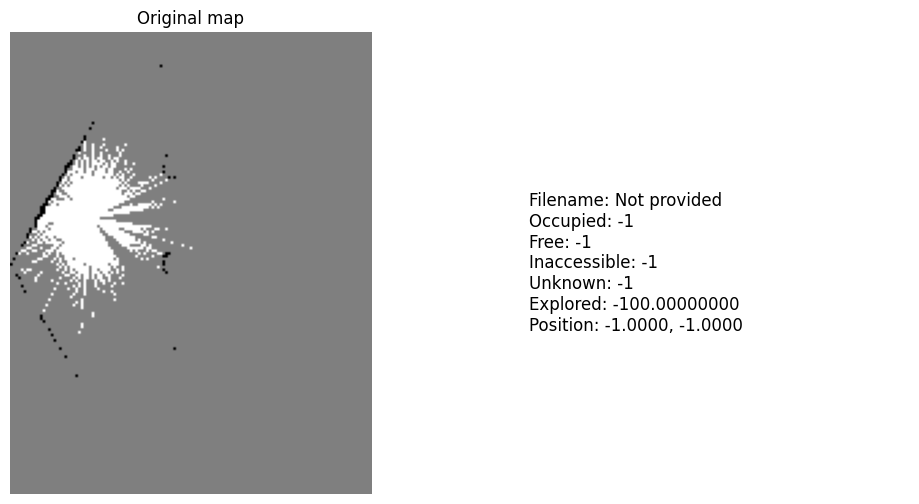

Marking position at world coordinates: (-1.999880189102671, -0.5000003201758468)
Converted to pixel coordinates: (30, 68)
explored %f not explored %f 0.05674480318443167 0.9432551968155684


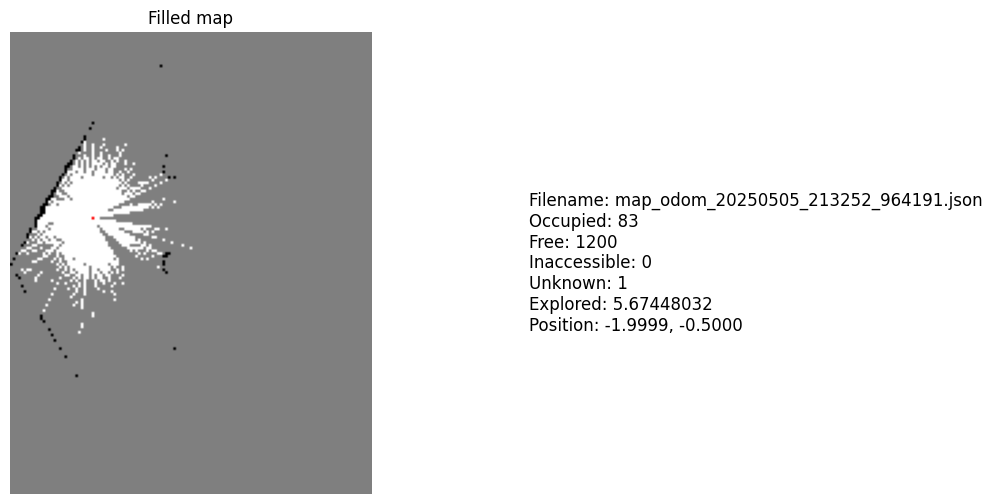

{'header': {'stamp': {'sec': 5, 'nanosec': 328000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 133, 'height': 170, 'origin': {'position': {'x': -2.9276428053780297, 'y': -2.5529621305117147, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

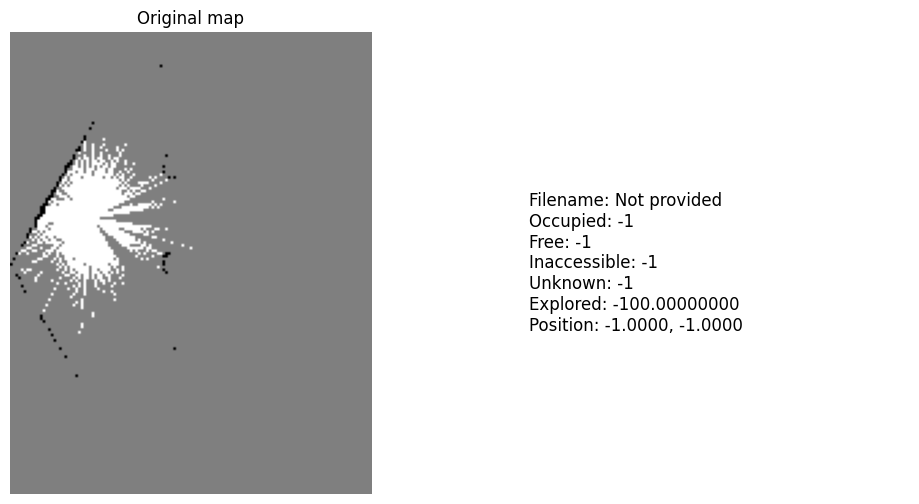

Marking position at world coordinates: (-1.9997669191276741, -0.5000001463771746)
Converted to pixel coordinates: (30, 68)
explored %f not explored %f 0.05674480318443167 0.9432551968155684


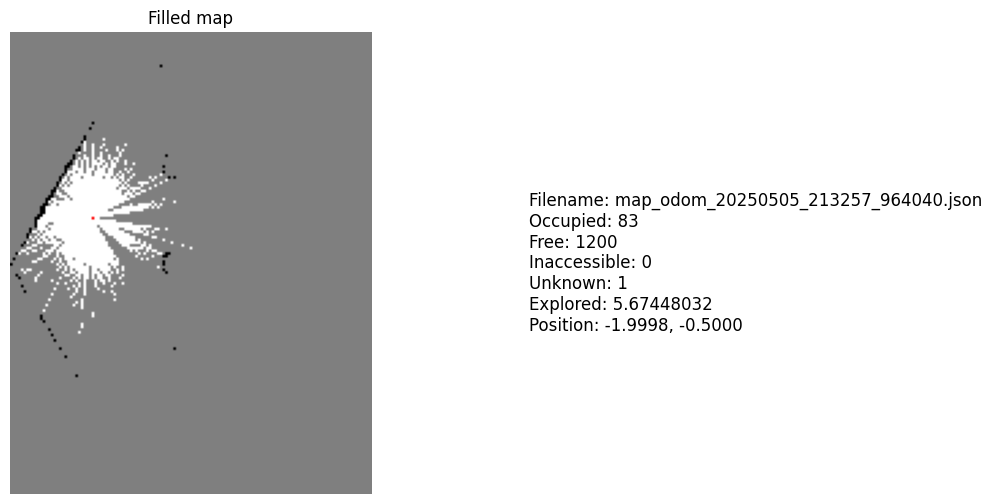

{'header': {'stamp': {'sec': 8, 'nanosec': 334000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 133, 'height': 170, 'origin': {'position': {'x': -2.9276428053780297, 'y': -2.5529621305117147, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

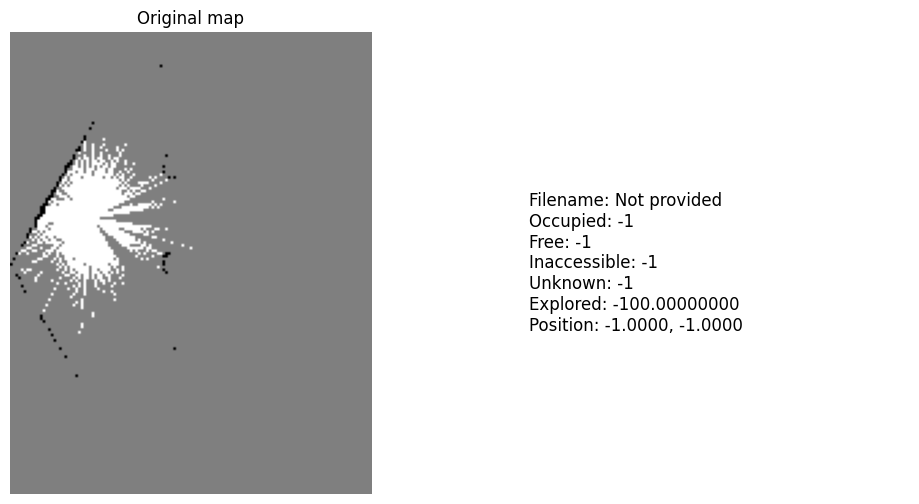

Marking position at world coordinates: (-1.9996579878031453, -0.5000000875797371)
Converted to pixel coordinates: (30, 68)
explored %f not explored %f 0.05674480318443167 0.9432551968155684


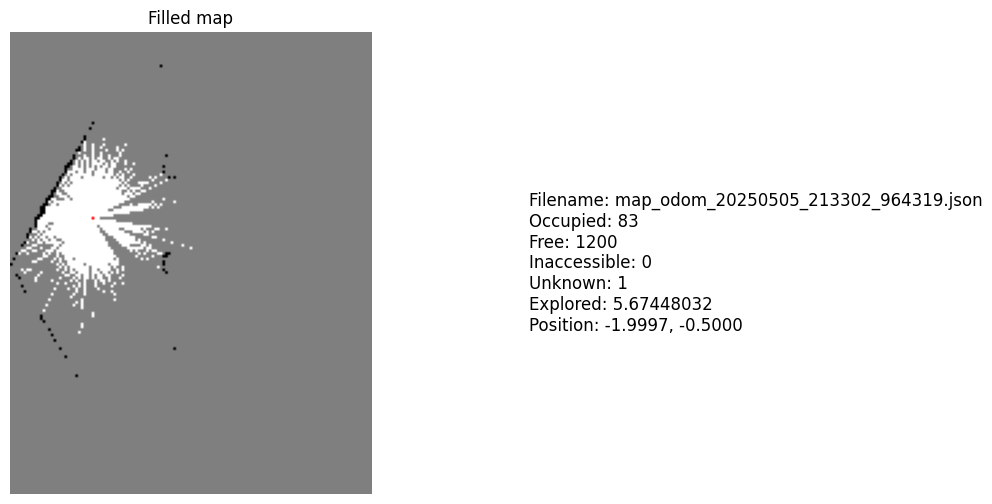

{'header': {'stamp': {'sec': 11, 'nanosec': 739000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 145, 'height': 171, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.5529621305117147, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

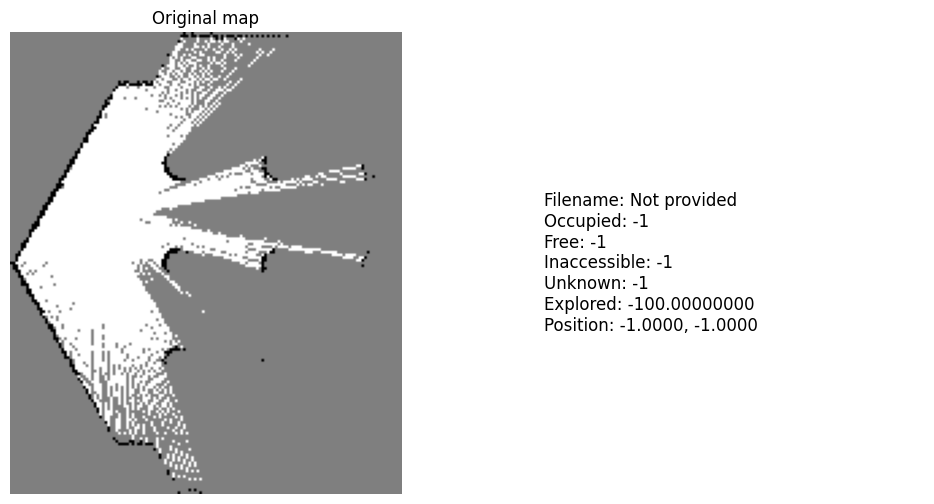

Marking position at world coordinates: (-1.7311158408390124, -0.6868463030292579)
Converted to pixel coordinates: (40, 62)
explored %f not explored %f 0.23456342004436379 0.7654365799556362


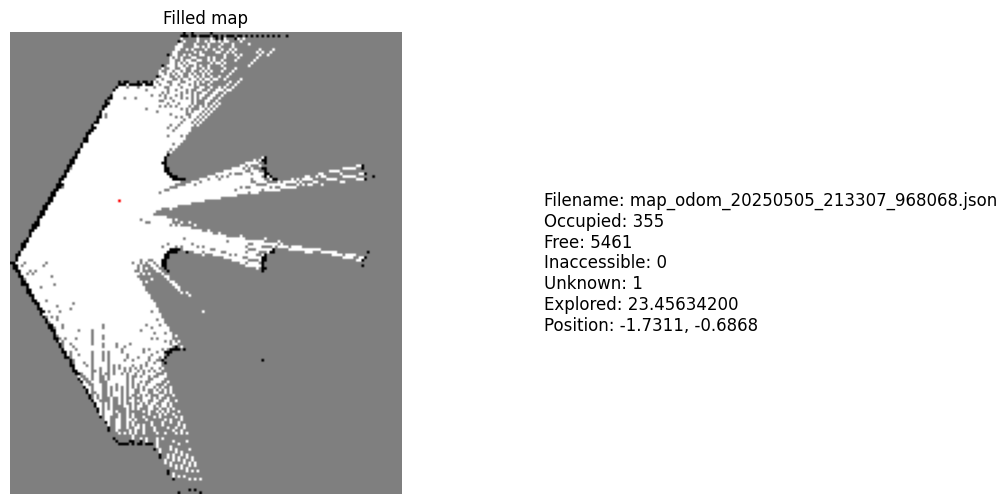

{'header': {'stamp': {'sec': 14, 'nanosec': 755000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 145, 'height': 171, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.5529621305117147, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

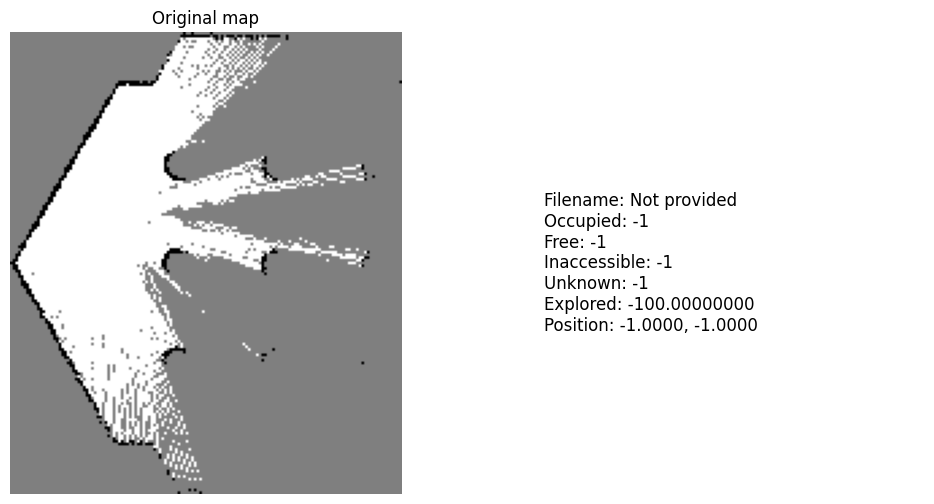

Marking position at world coordinates: (-1.4442527294827656, -1.4281377779044462)
Converted to pixel coordinates: (50, 37)
explored %f not explored %f 0.2698527929017947 0.7301472070982054


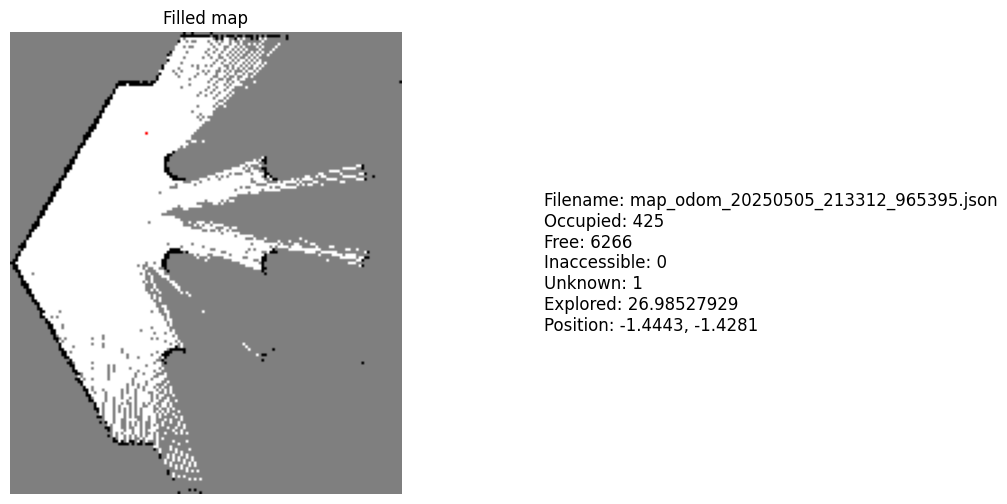

{'header': {'stamp': {'sec': 17, 'nanosec': 777000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 170, 'height': 171, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.5529621305117147, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

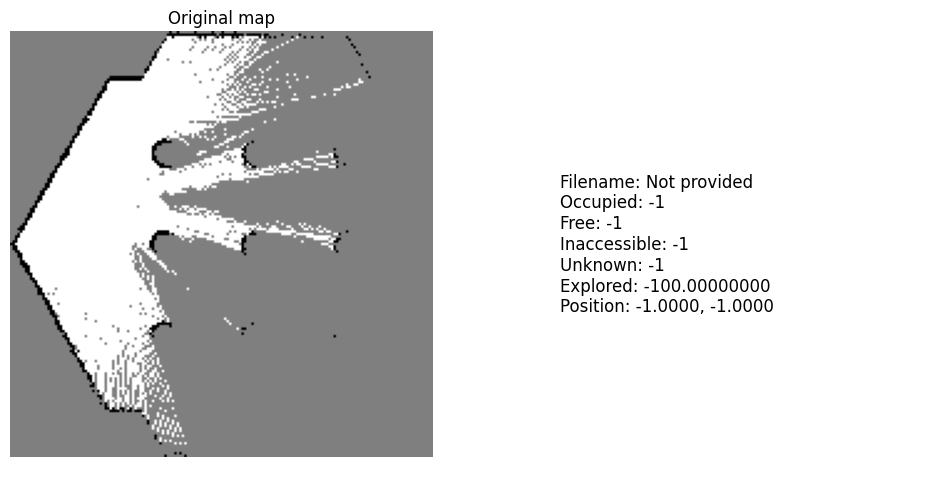

Marking position at world coordinates: (-1.0010044423043258, -1.9099297768536871)
Converted to pixel coordinates: (65, 21)
explored %f not explored %f 0.25579635362917097 0.744203646370829


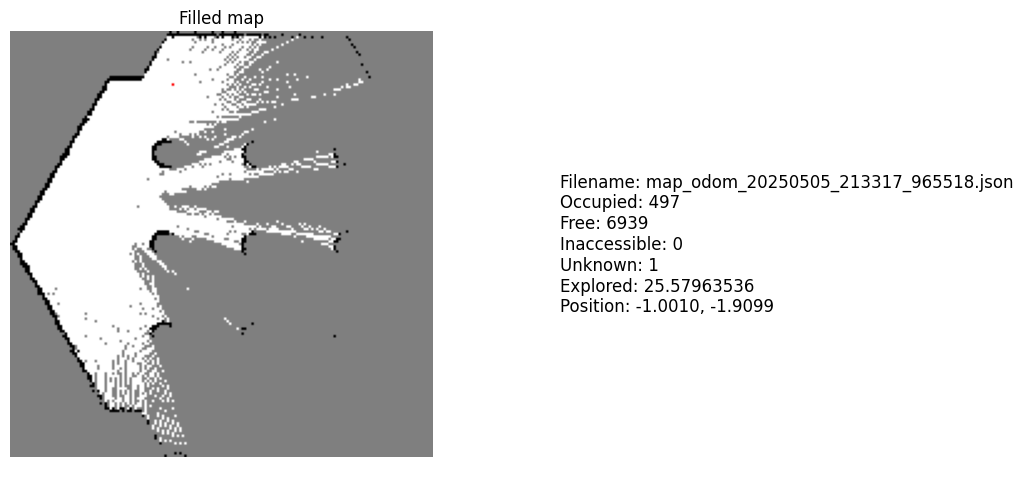

{'header': {'stamp': {'sec': 20, 'nanosec': 795000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 180, 'height': 171, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.5606957701973174, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, 100, 100, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

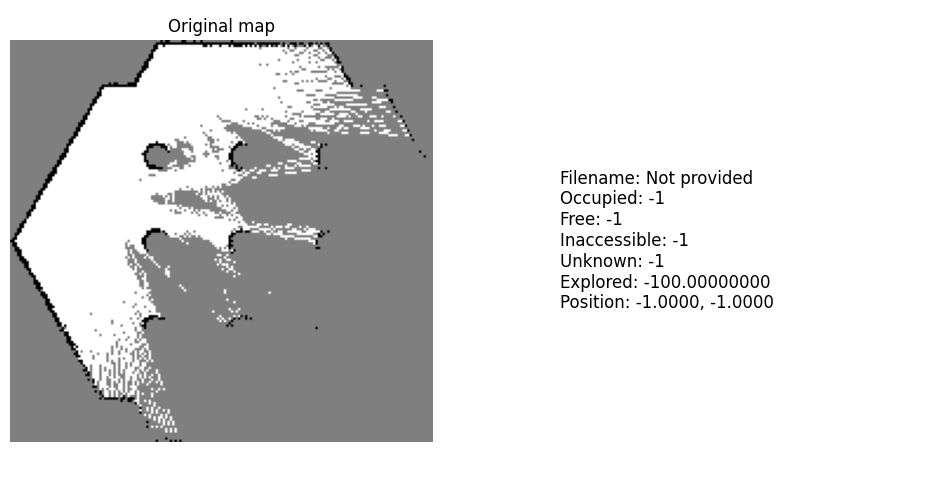

Marking position at world coordinates: (-0.257803663046169, -1.9445478841783639)
Converted to pixel coordinates: (89, 20)
explored %f not explored %f 0.3104288499025341 0.689571150097466


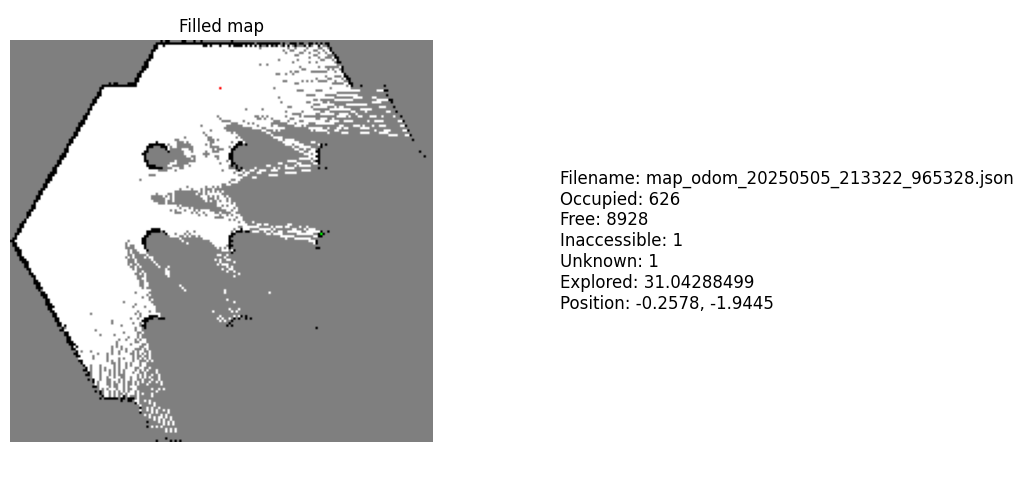

{'header': {'stamp': {'sec': 24, 'nanosec': 25000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 187, 'height': 171, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

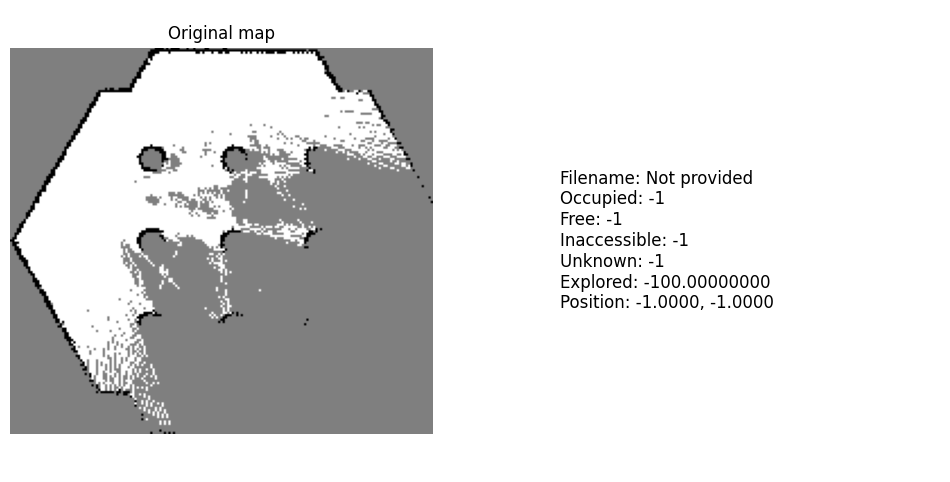

Marking position at world coordinates: (0.508886293373191, -1.8433984899197204)
Converted to pixel coordinates: (115, 23)
explored %f not explored %f 0.3454983269224755 0.6545016730775245


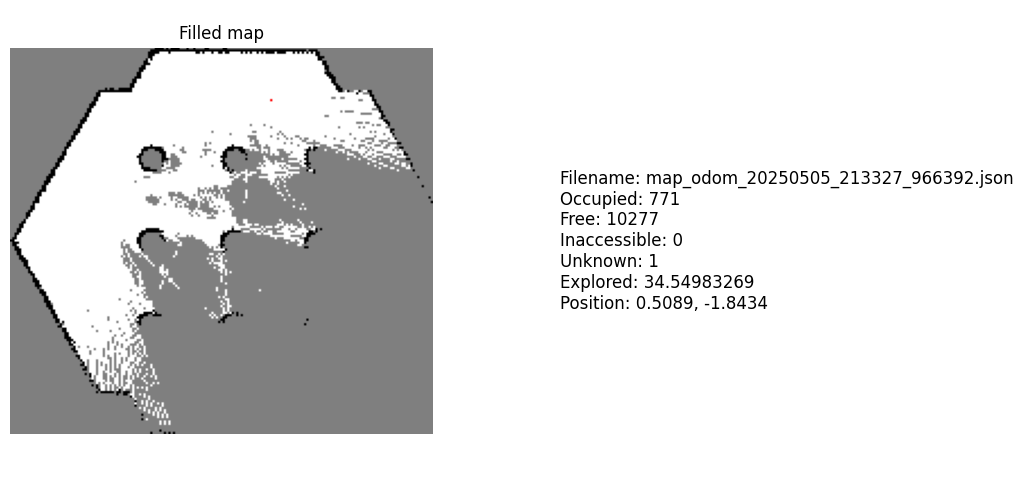

{'header': {'stamp': {'sec': 26, 'nanosec': 849000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 187, 'height': 171, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

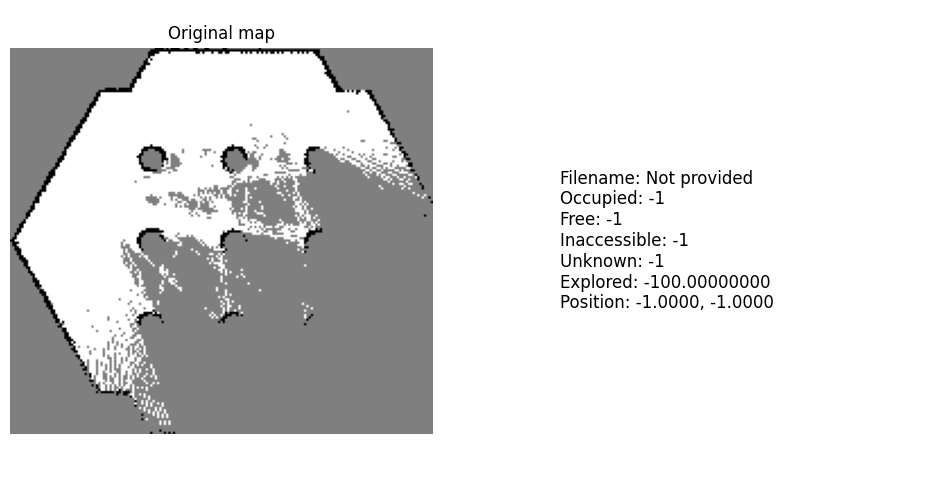

Marking position at world coordinates: (1.1745158404672293, -1.6491965279524783)
Converted to pixel coordinates: (137, 30)
explored %f not explored %f 0.3647309003346155 0.6352690996653845


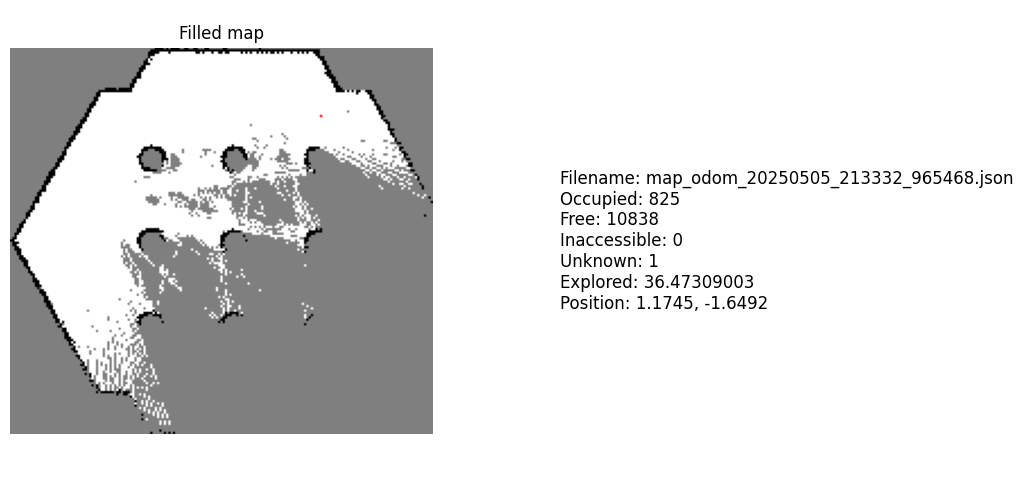

{'header': {'stamp': {'sec': 29, 'nanosec': 673000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 171, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

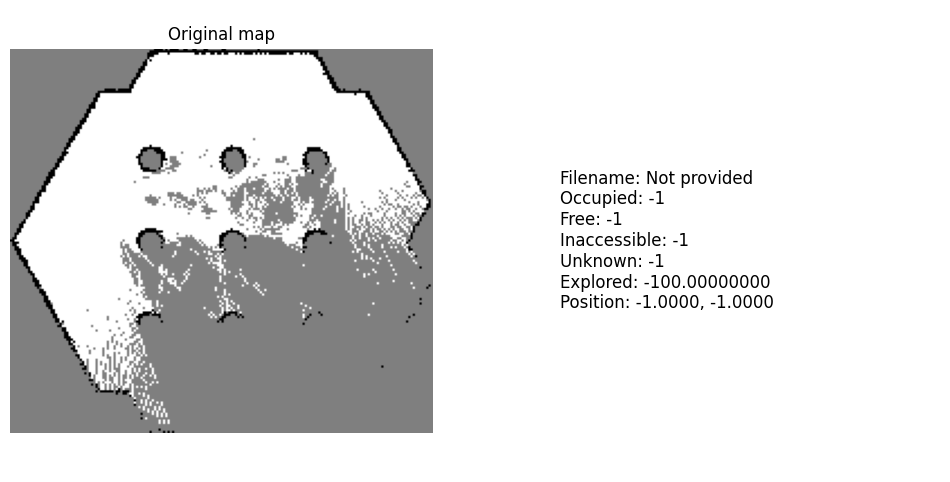

Marking position at world coordinates: (1.672327855341124, -1.1406175955160769)
Converted to pixel coordinates: (154, 47)
explored %f not explored %f 0.40633943013562274 0.5936605698643773


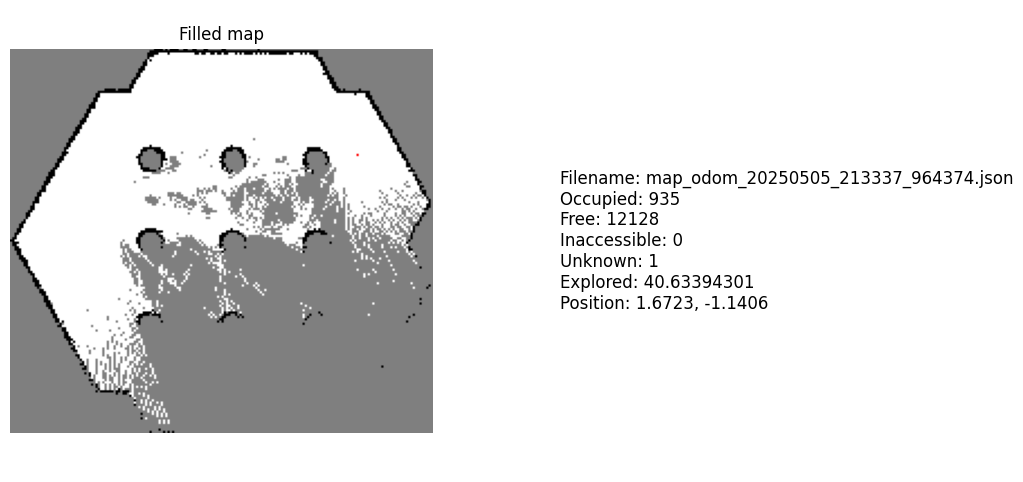

{'header': {'stamp': {'sec': 32, 'nanosec': 886000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 171, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

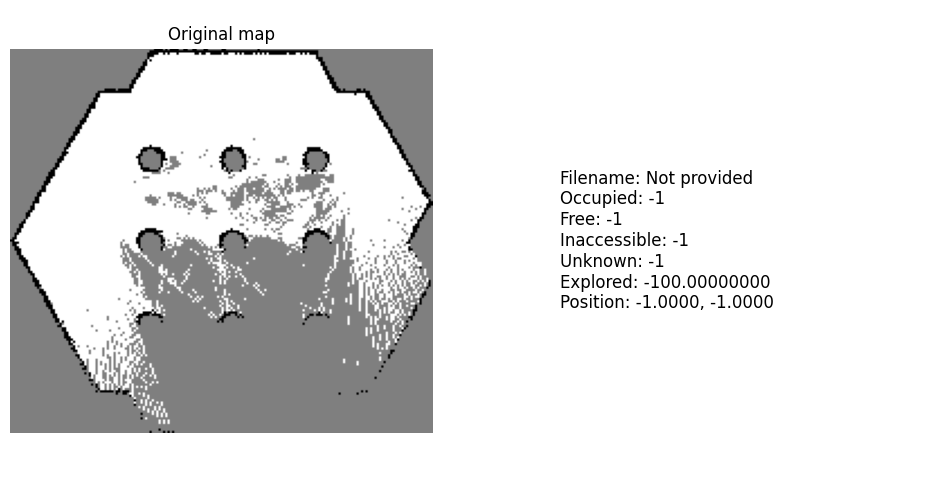

Marking position at world coordinates: (1.7919166827751865, -0.3934776490955073)
Converted to pixel coordinates: (158, 72)
explored %f not explored %f 0.4507900958068931 0.5492099041931069


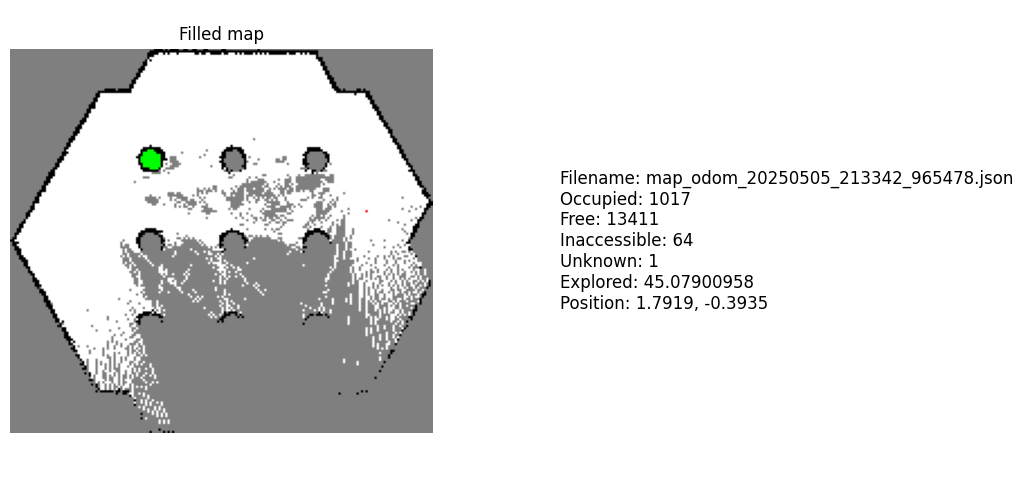

{'header': {'stamp': {'sec': 35, 'nanosec': 893000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 172, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

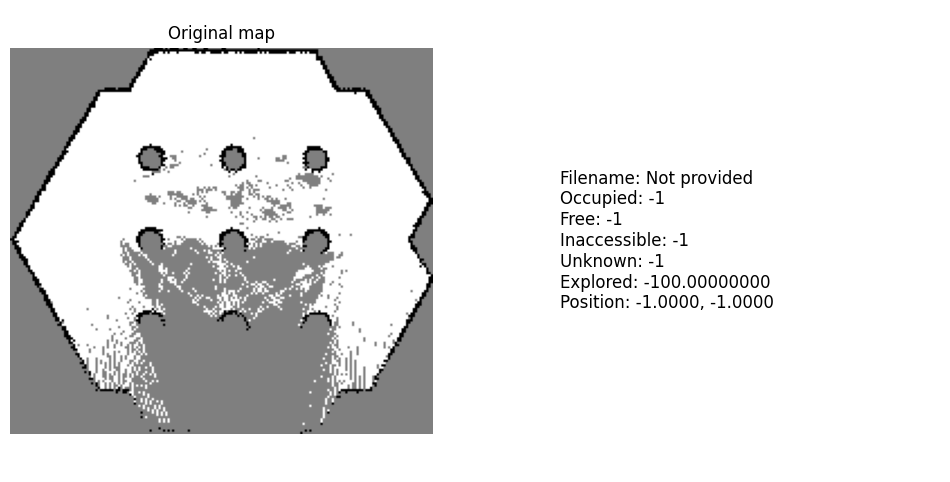

Marking position at world coordinates: (1.7975462762920187, 0.36429304366511805)
Converted to pixel coordinates: (158, 97)
explored %f not explored %f 0.5149678377041069 0.4850321622958931


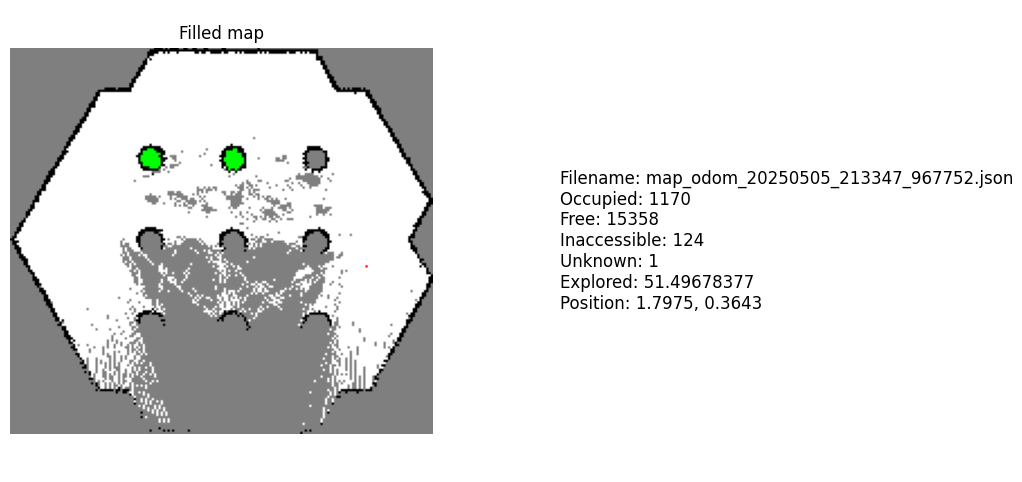

{'header': {'stamp': {'sec': 38, 'nanosec': 911000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 172, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

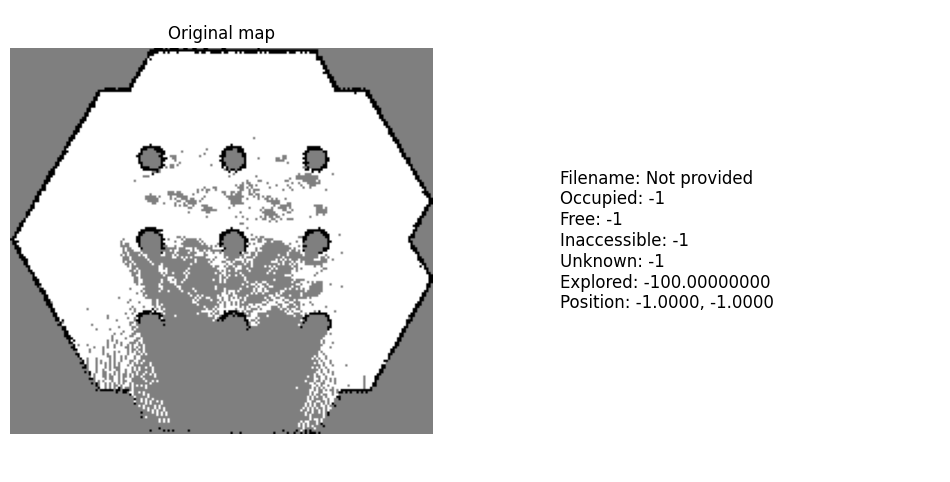

Marking position at world coordinates: (1.7325235911959815, 0.9697345815835193)
Converted to pixel coordinates: (156, 117)
explored %f not explored %f 0.5380999505195447 0.46190004948045527


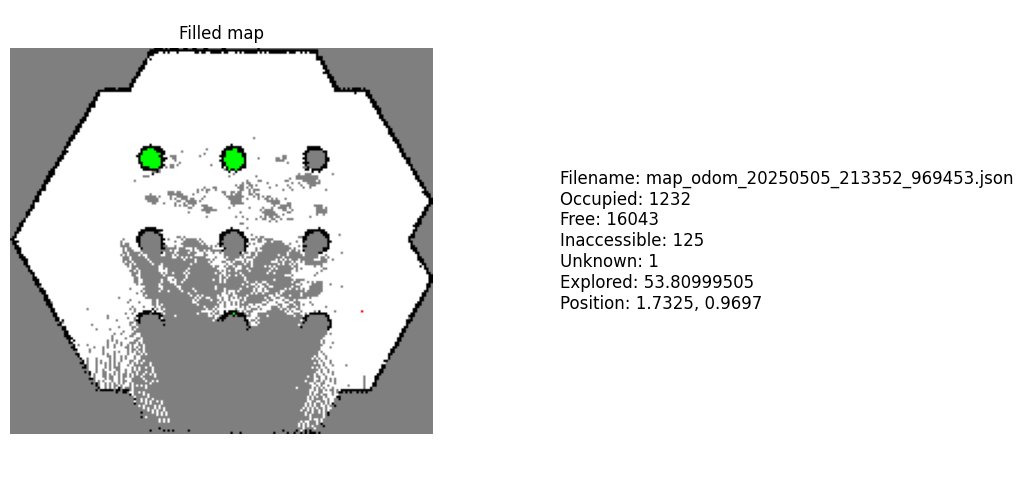

{'header': {'stamp': {'sec': 41, 'nanosec': 925000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 178, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

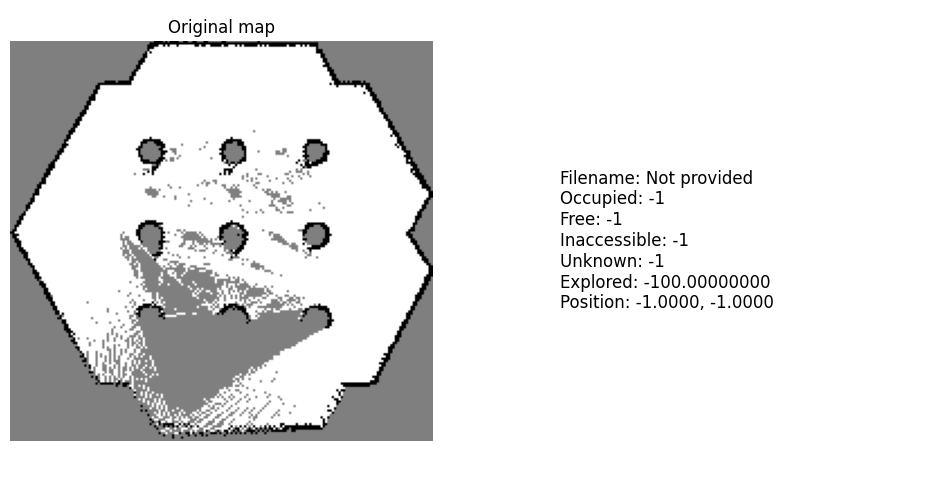

Marking position at world coordinates: (1.528309503264769, 1.08018134660543)
Converted to pixel coordinates: (149, 121)
explored %f not explored %f 0.5978663638536935 0.4021336361463065


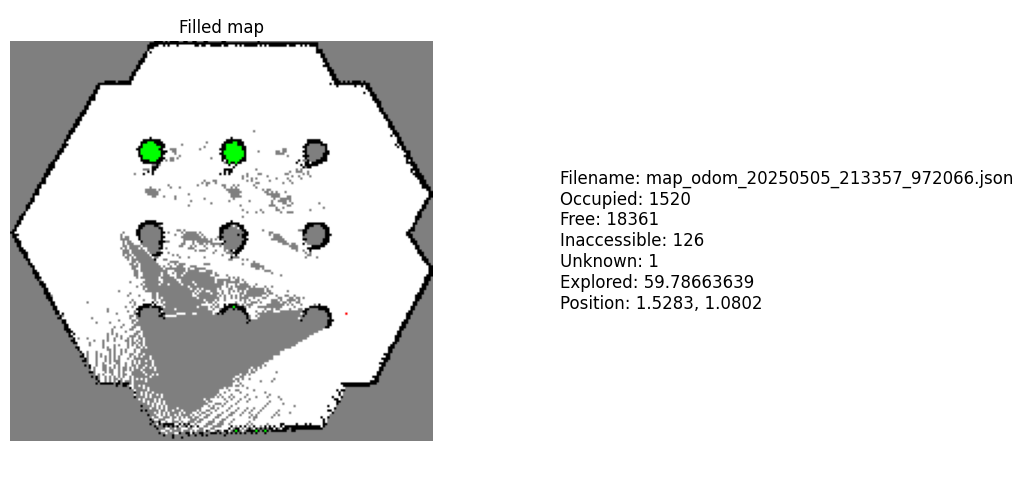

{'header': {'stamp': {'sec': 44, 'nanosec': 749000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 178, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

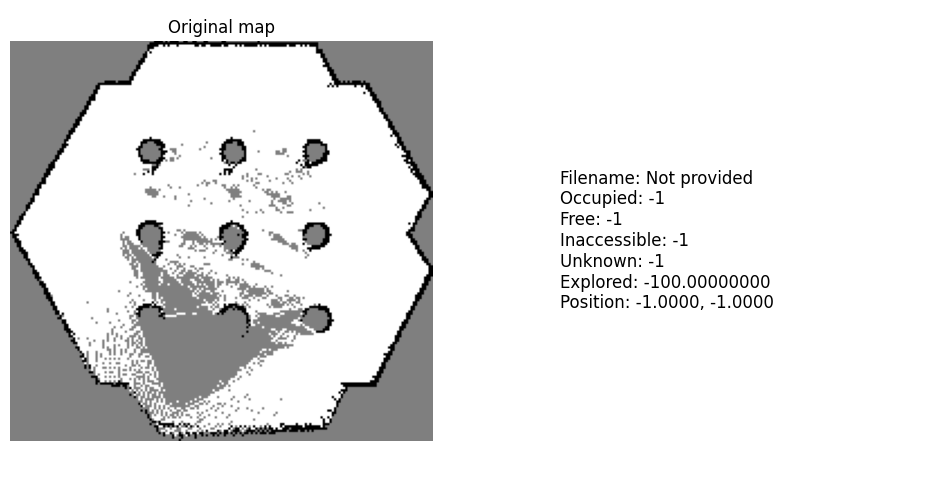

Marking position at world coordinates: (1.1841934106817467, 1.5968367909973011)
Converted to pixel coordinates: (137, 138)
explored %f not explored %f 0.6166327994262492 0.38336720057375084


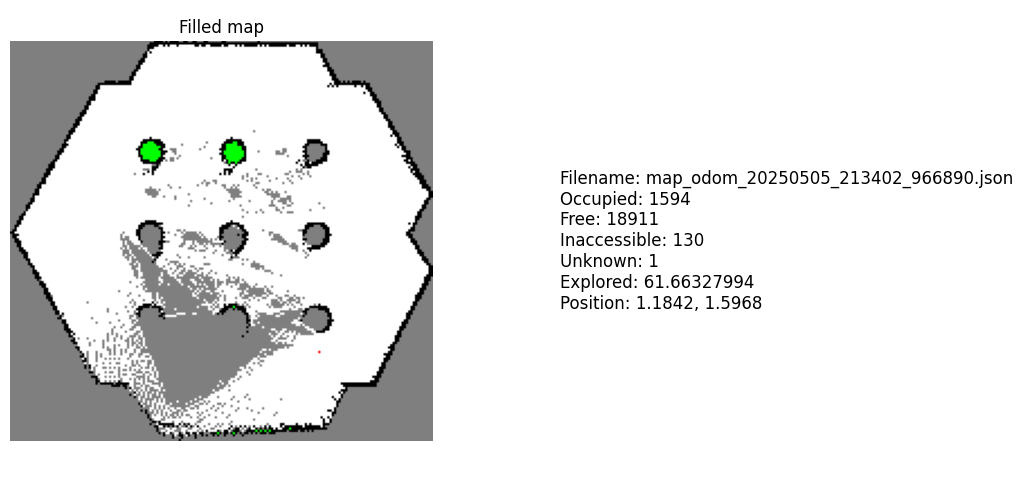

{'header': {'stamp': {'sec': 47, 'nanosec': 768000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 178, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

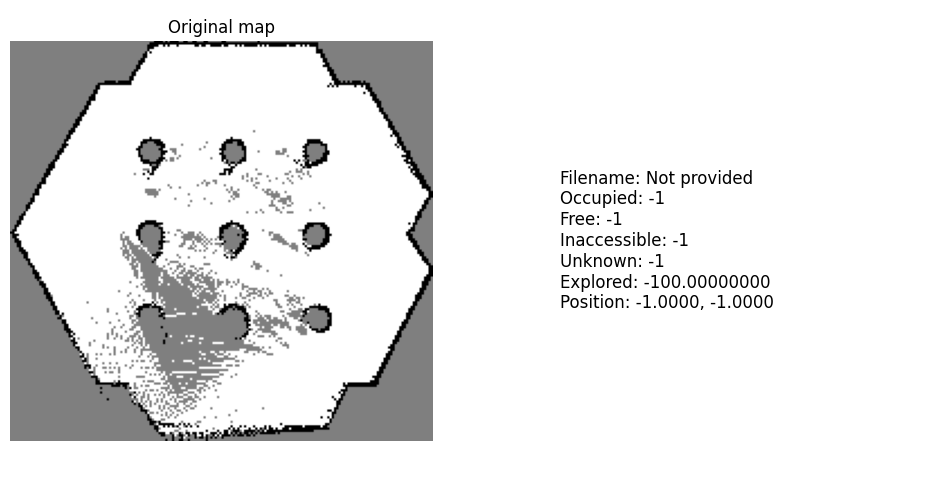

Marking position at world coordinates: (0.45222527707913557, 1.8258958761878372)
Converted to pixel coordinates: (113, 146)
explored %f not explored %f 0.644364092756395 0.35563590724360505


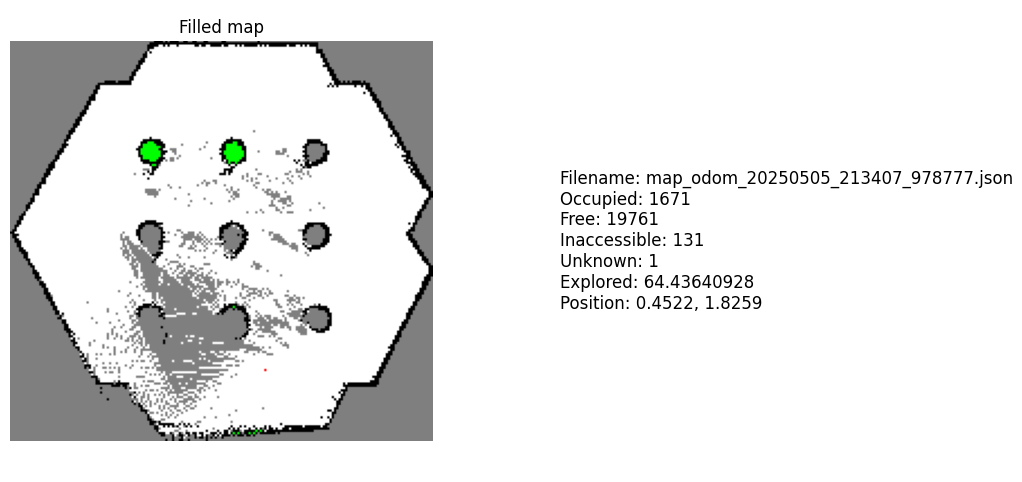

{'header': {'stamp': {'sec': 50, 'nanosec': 577000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 180, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

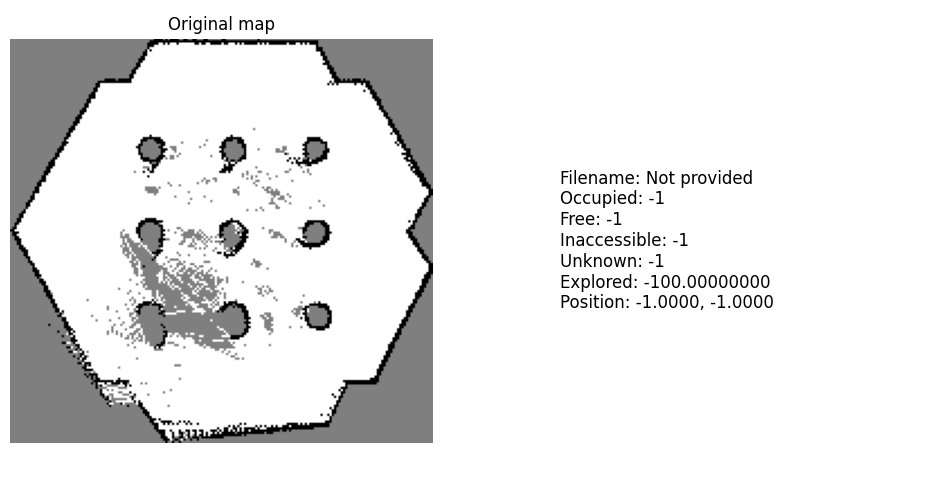

Marking position at world coordinates: (0.1616691301824395, 1.9943053235367845)
Converted to pixel coordinates: (103, 151)
explored %f not explored %f 0.6746749408983451 0.3253250591016549


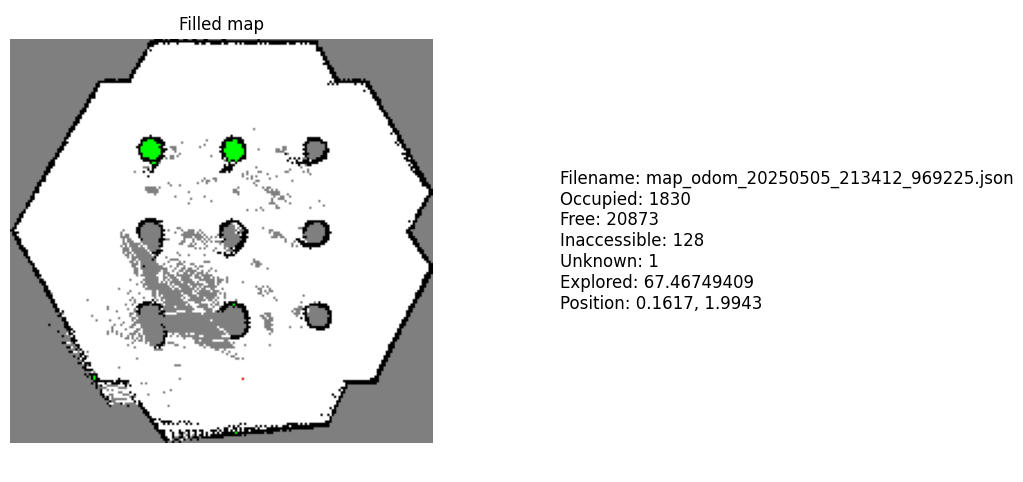

{'header': {'stamp': {'sec': 53, 'nanosec': 787000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 180, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

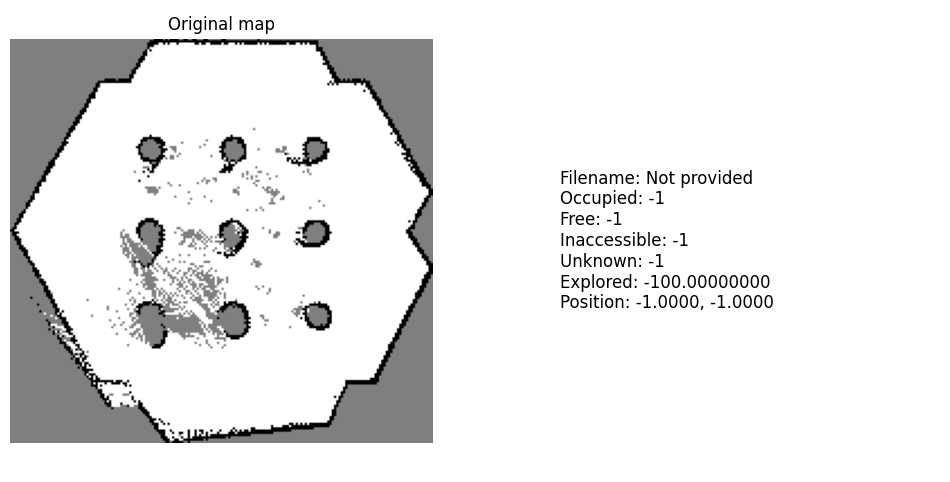

Marking position at world coordinates: (-0.5916730618769385, 1.7919808476217958)
Converted to pixel coordinates: (78, 145)
explored %f not explored %f 0.6921690307328605 0.3078309692671395


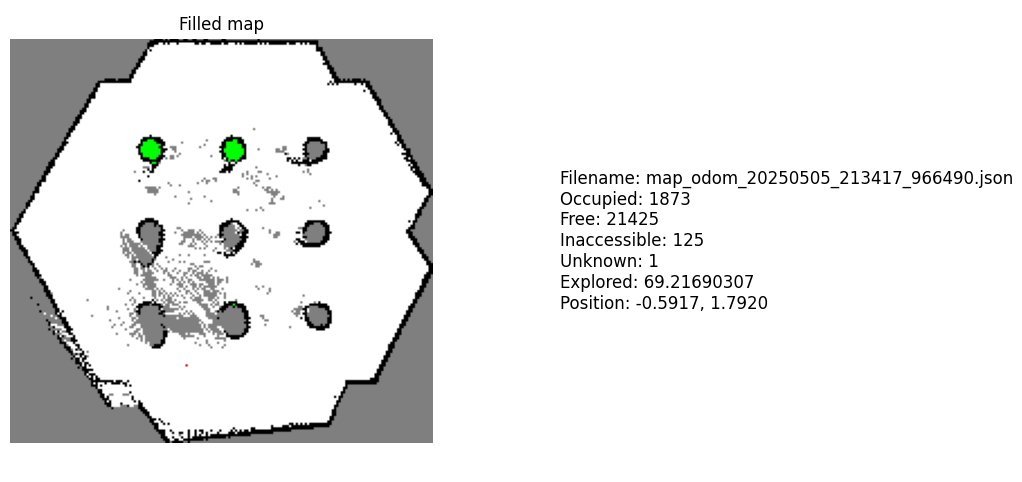

{'header': {'stamp': {'sec': 56, 'nanosec': 792000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 190, 'height': 180, 'origin': {'position': {'x': -3.015080931134698, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

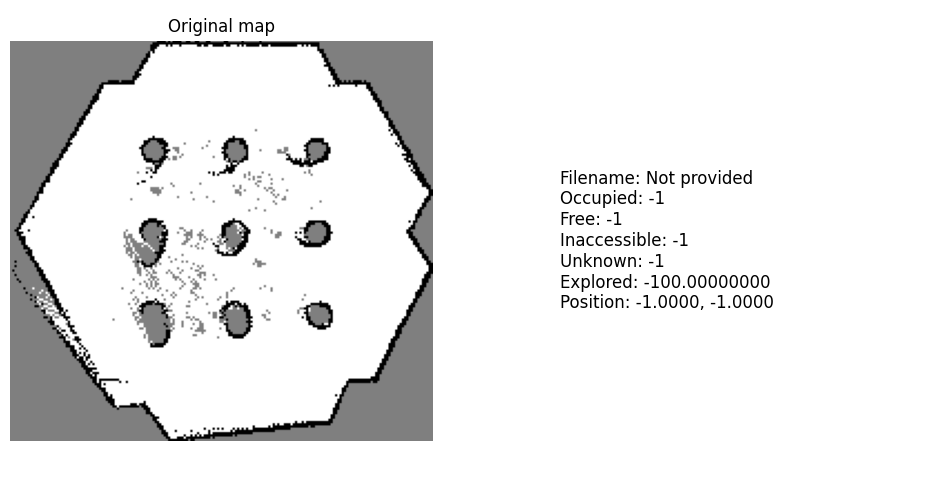

Marking position at world coordinates: (-1.2766883830497004, 1.4992729381306396)
Converted to pixel coordinates: (57, 135)
explored %f not explored %f 0.7026608187134503 0.2973391812865497


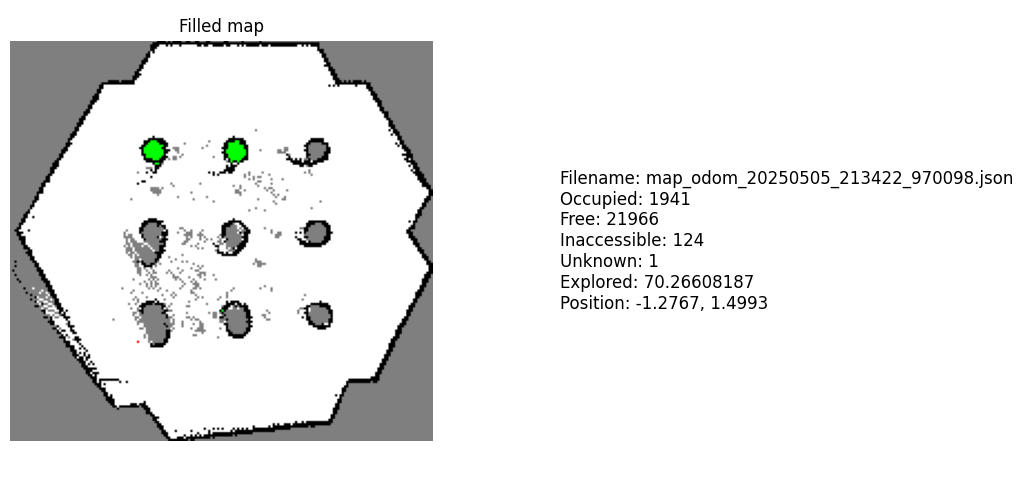

{'header': {'stamp': {'sec': 59, 'nanosec': 605000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 190, 'height': 181, 'origin': {'position': {'x': -3.015080931134698, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

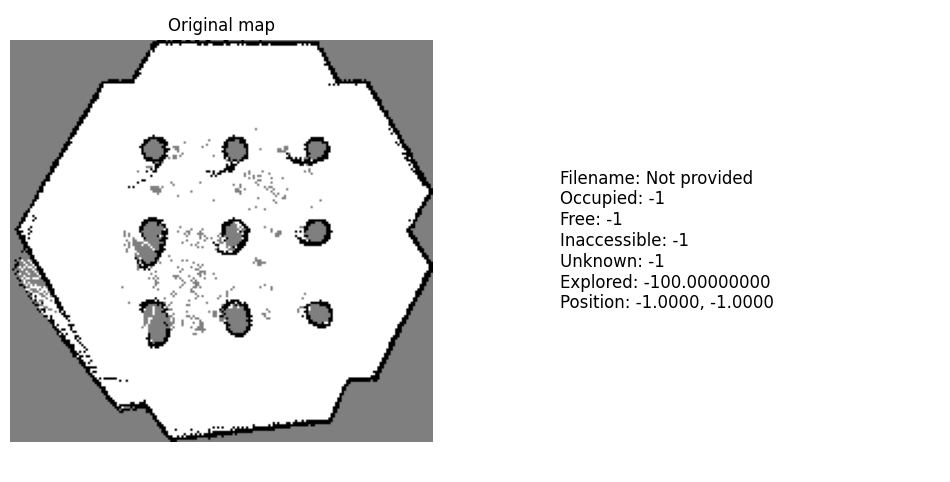

Marking position at world coordinates: (-1.6840109369949363, 0.9500085382451664)
Converted to pixel coordinates: (44, 117)
explored %f not explored %f 0.7065425995929049 0.2934574004070951


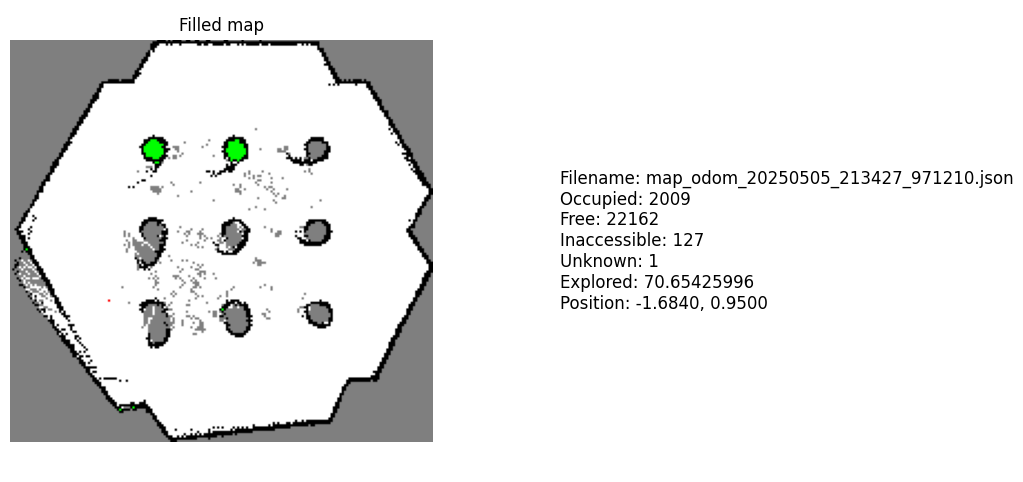

{'header': {'stamp': {'sec': 62, 'nanosec': 417000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 187, 'height': 174, 'origin': {'position': {'x': -2.9626397491207124, 'y': -2.6577183216049107, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

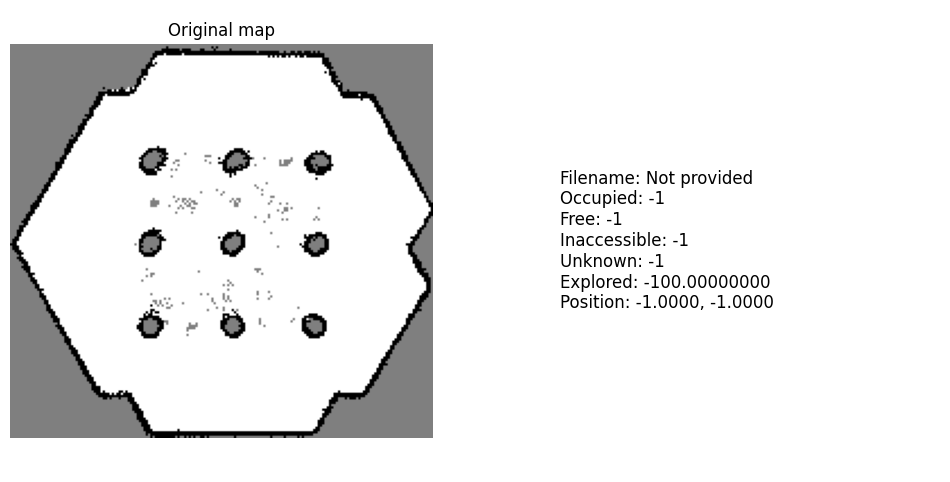

Marking position at world coordinates: (-1.688040921568388, 0.6603907600943973)
Converted to pixel coordinates: (42, 110)
explored %f not explored %f 0.7325895875591616 0.2674104124408384


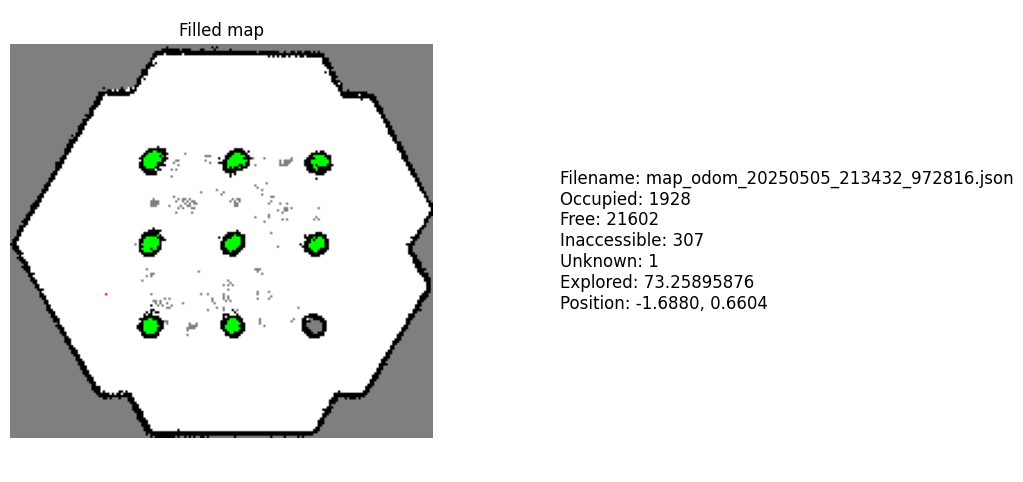

{'header': {'stamp': {'sec': 65, 'nanosec': 431000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 174, 'origin': {'position': {'x': -2.967012748756958, 'y': -2.6577183216049107, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

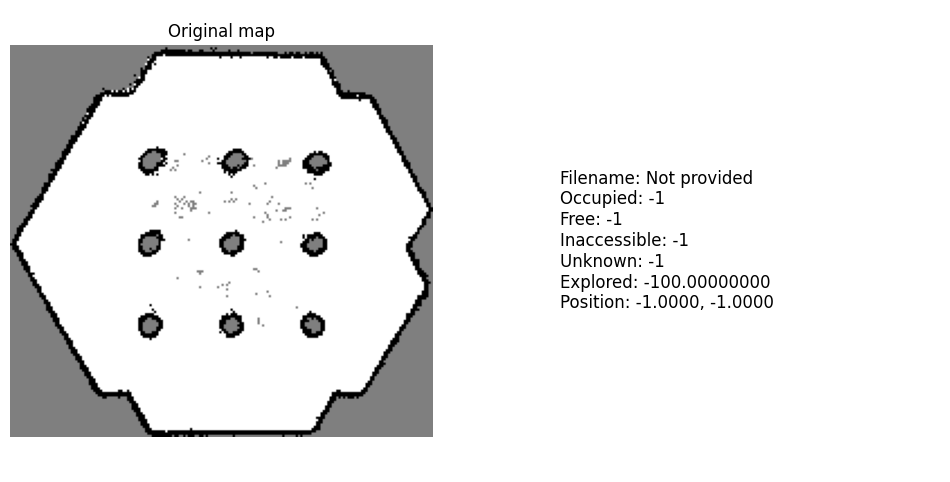

Marking position at world coordinates: (-1.205744254930727, 0.41604030622451377)
Converted to pixel coordinates: (58, 102)
explored %f not explored %f 0.732605771582294 0.267394228417706


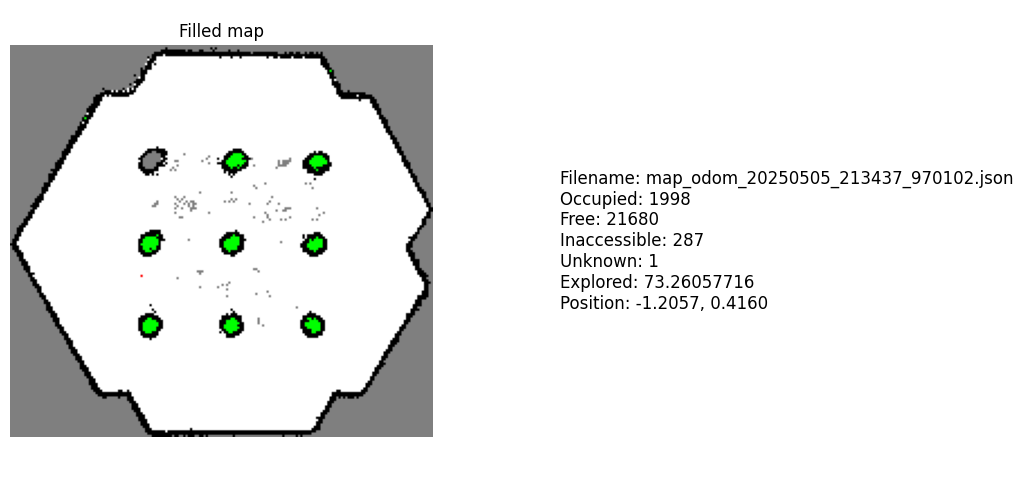

{'header': {'stamp': {'sec': 68, 'nanosec': 249000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 174, 'origin': {'position': {'x': -2.967012748756958, 'y': -2.6577183216049107, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

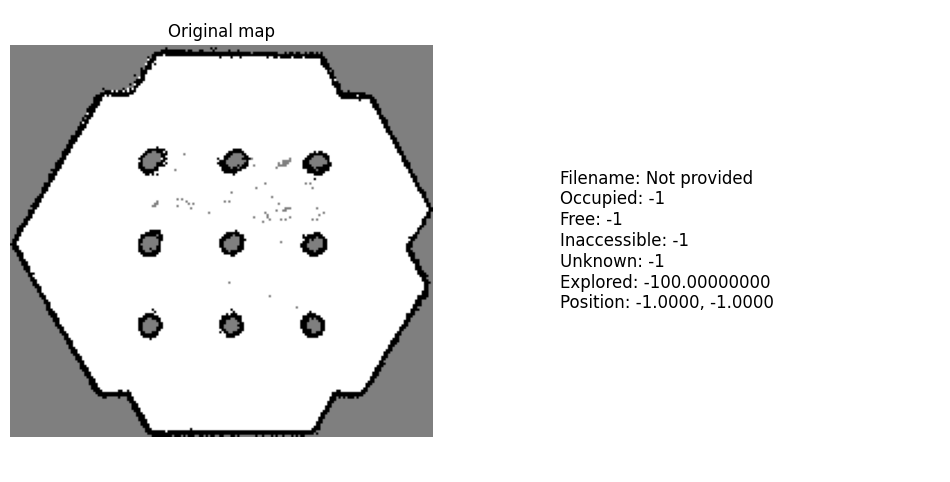

Marking position at world coordinates: (-0.5921602078645649, 0.5911427223307649)
Converted to pixel coordinates: (79, 108)
explored %f not explored %f 0.7350513573000733 0.2649486426999267


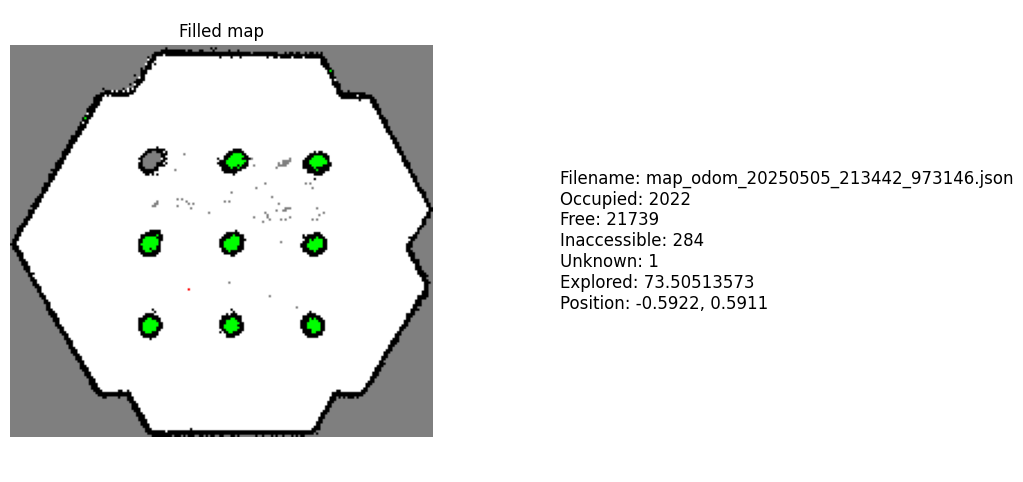

{'header': {'stamp': {'sec': 70, 'nanosec': 853000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 174, 'origin': {'position': {'x': -2.967012748756958, 'y': -2.6577183216049107, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

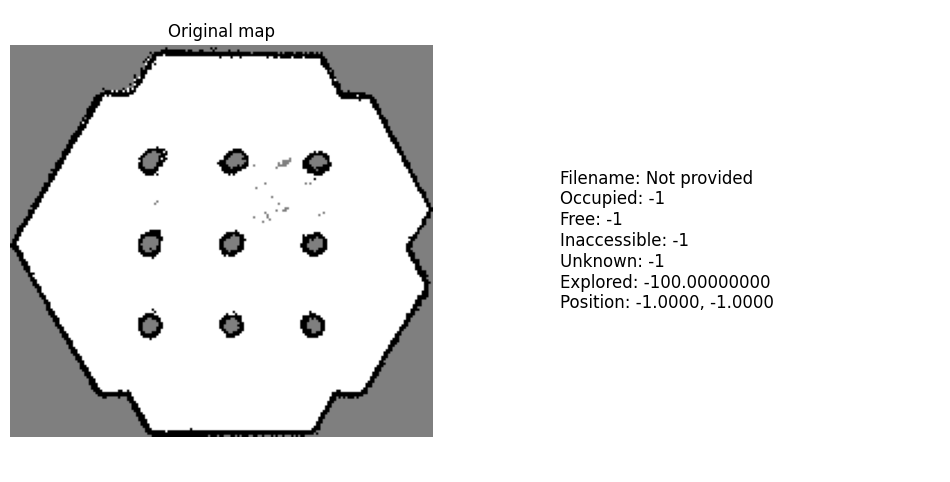

Marking position at world coordinates: (0.048041823512246805, 0.5233781097991201)
Converted to pixel coordinates: (100, 106)
explored %f not explored %f 0.7382000489117143 0.2617999510882857


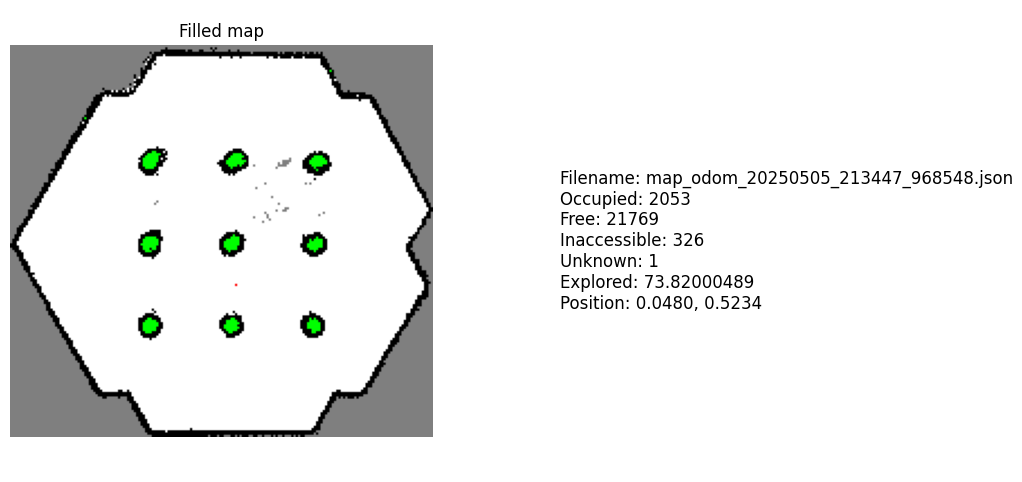

{'header': {'stamp': {'sec': 73, 'nanosec': 863000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 174, 'origin': {'position': {'x': -2.967012748756958, 'y': -2.6577183216049107, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

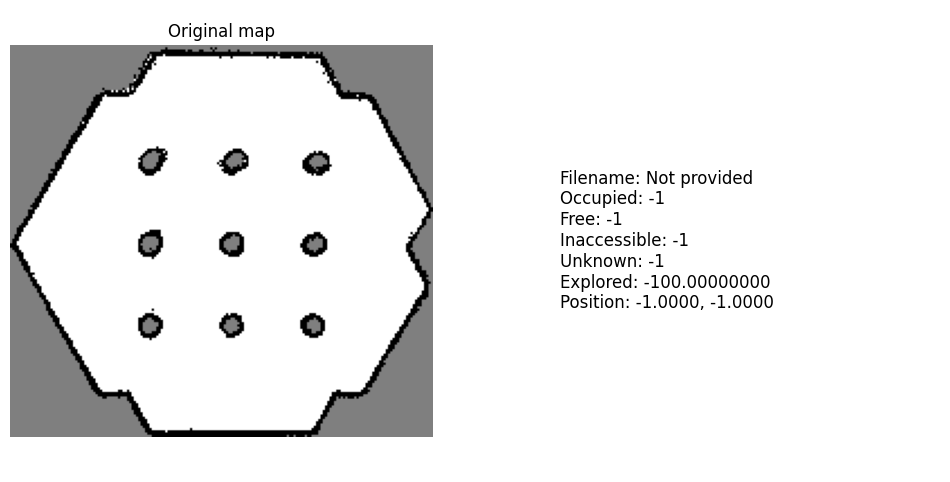

Marking position at world coordinates: (0.5247696476021114, -0.030563204813500087)
Converted to pixel coordinates: (116, 87)
explored %f not explored %f 0.739667400342382 0.260332599657618


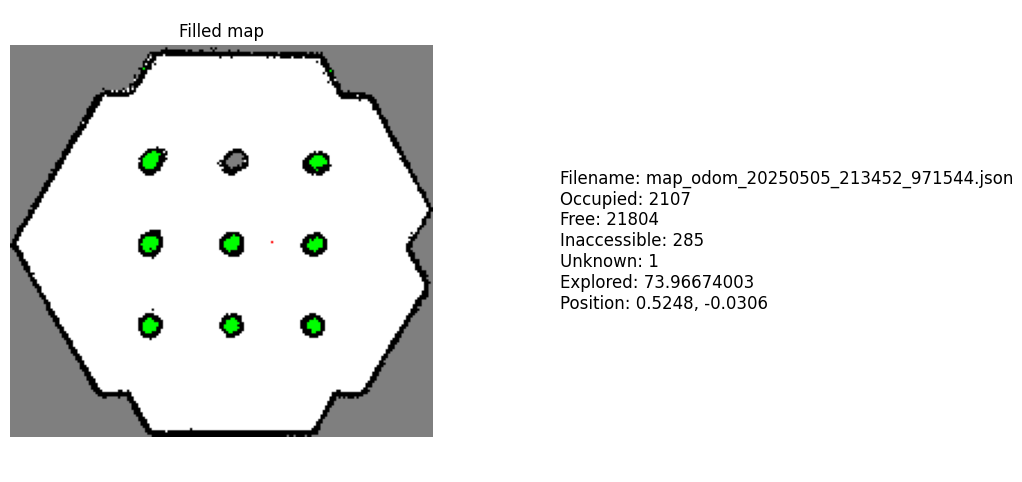

{'header': {'stamp': {'sec': 76, 'nanosec': 675000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 174, 'origin': {'position': {'x': -2.967012748756958, 'y': -2.6577183216049107, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

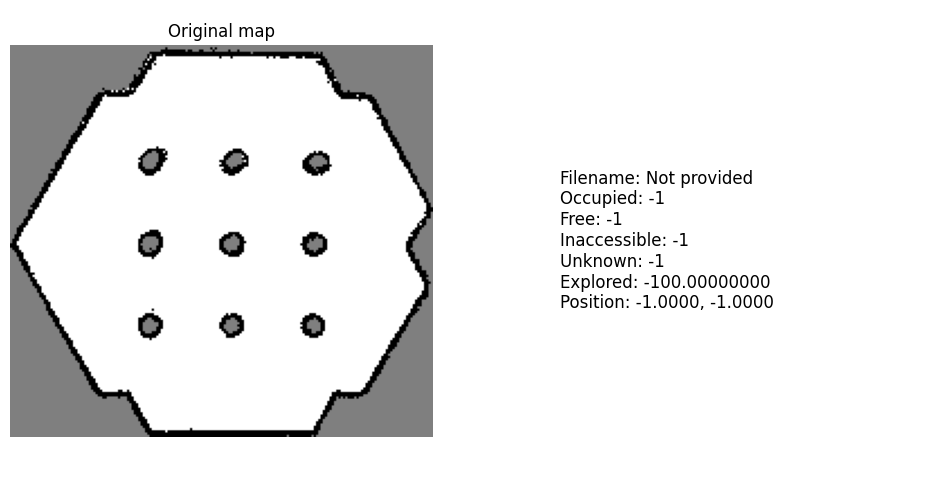

Marking position at world coordinates: (0.09755520395604113, -0.5436258284970026)
Converted to pixel coordinates: (102, 70)
explored %f not explored %f 0.740309366593299 0.25969063340670095


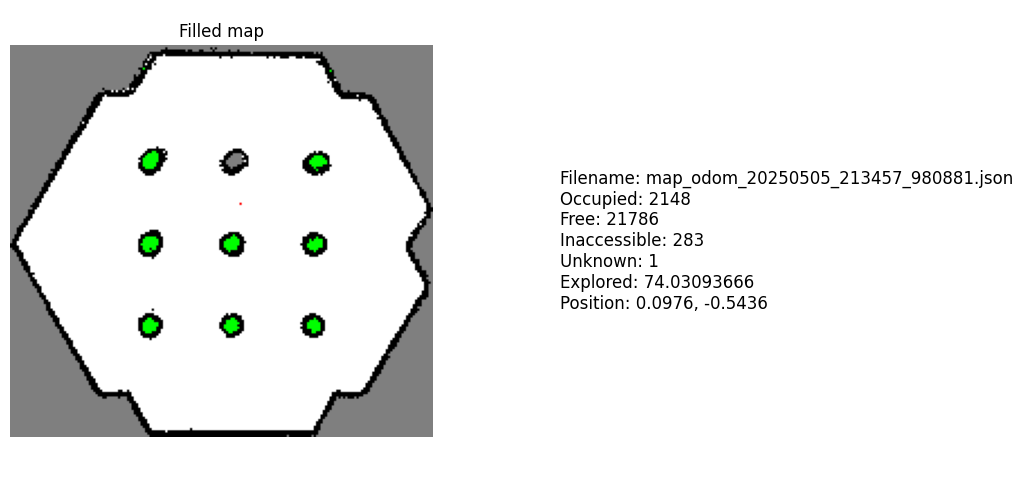

{'header': {'stamp': {'sec': 79, 'nanosec': 88000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 174, 'origin': {'position': {'x': -2.9737276014344483, 'y': -2.6577183216049107, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

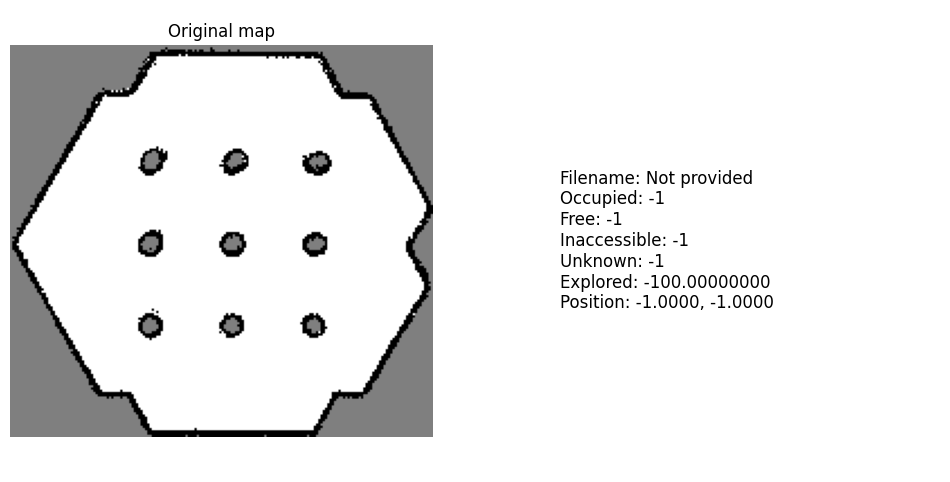

Marking position at world coordinates: (-0.4769115706557633, -0.5974470461210657)
Converted to pixel coordinates: (83, 68)
explored %f not explored %f 0.7395756908779653 0.26042430912203474


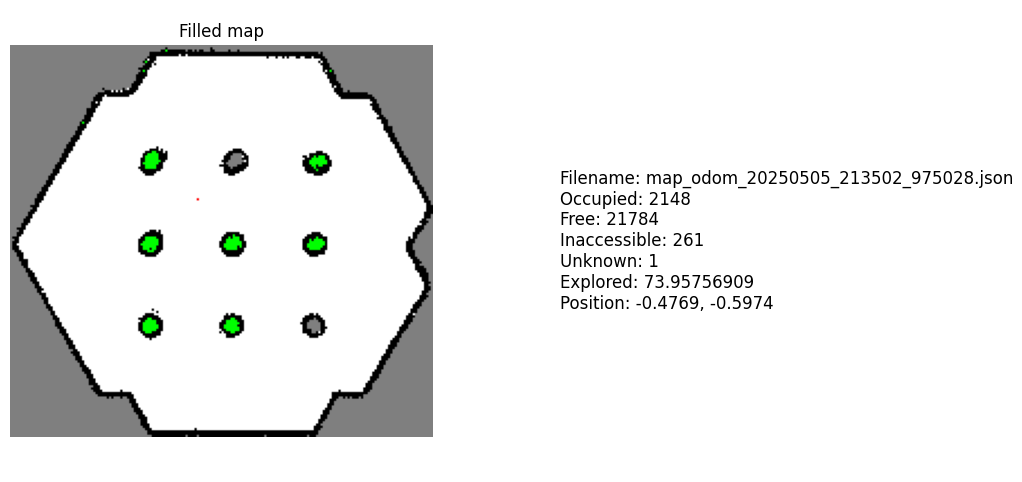

In [19]:
filenames = [_f.name for _f in os.scandir(DIRPATH) if _f.is_file()]
filenames.sort()

for _f in filenames:
    # print(_f)
    _grid, origin_x, origin_y = read_data_map(DIRPATH, _f)
    pos_x, pos_y = read_data_odom(DIRPATH, _f)
    print_plot_v2(_grid, title="Original map")
    
    filled_grid = fill_enclosed_unknowns_v2(_grid)
    fully_enclosed = is_fully_enclosed(filled_grid)
    # print(fully_enclosed, _f)
    if fully_enclosed: filled_grid = fill_outside_with_100(filled_grid)
    
    filled_grid = mark_position(filled_grid, pos_x, pos_y, origin_x, origin_y)
    
    occupied,\
    free,\
    inaccessible,\
    unknown,\
    explored_percent = calculate_remaining_space(filled_grid)
    print_plot_v2(
        filled_grid,
        title=f"Filled map",
        filename=_f,
        occupied=occupied,
        free=free,
        inaccessible=inaccessible,
        unknown=unknown,
        explored_percent=explored_percent,
        position_x=pos_x,
        position_y=pos_y
    )
    
    # break
    
    # TODO create fucntion to fill outer space / not calculate the remaining outer space